# Exercice 6 : Apprentissage supervisé

## Dataset

https://database.lichess.org/

Notre dataset provient de *Lichess*, une des plus grandes plateformes d'échecs multijoueurs en ligne (et c'est francais !). Elle met à disposition toutes les parties d'échecs qui sont jouées sur la plateforme. Les données sont regroupées par mois dans le format `pgn` (voir https://fr.wikipedia.org/wiki/Portable_Game_Notation). Dans les grandes lignes, ce format nous permet de retrouver l'elo des joueurs jouant les parties ainsi que leurs déplacement sur l'échiquier. L'elo étant le 'score' d'une joueur, plus son elo est élevé, plus il est considéré comme fort. En effet, on gagne des points d'elo en gagnant des parties et on perds des points en perdant des parties (voir https://fr.wikipedia.org/wiki/Classement_Elo)

Pour simplifier l'apprentissage, nous allons uniquement nous concentrer sur le mois de juillet 2014 car il est plus léger que les autres (moins de parties).

### Explication de la problématique

A travers cet exercice, nous allons tenter de prédire l'elo de la partie (moyenne de l'elo des blancs et des noirs) à partir de plusieurs caractéristiques présentes dans le dataset (nombre de coups, patternes de mouvements, ouverture...). Nous allons donc tenter de résoudre un problème de classification : déterminer la tranche d'elo de la partie.

### Import du dataset

In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers, models

import optuna

2025-07-03 15:14:25.238203: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Chargement et nettoyage du dataset

Le processus de chargement et de nettoyage du dataset est assez couteux en mémoire, nous mettons en place une limite du nombre de ligne du dataset que nous souhaitons lire afin d'aller plus vite.

In [21]:
LIMIT = 200000

In [22]:
with open("lichess_db_standard_rated_2014-07.pgn") as f:
    i = 0
    data = ""
    for l in f:
        i += 1
        data += l
        if i > LIMIT:
            break

moves = re.findall("\[WhiteElo \"(\d+)\"\]\n\[BlackElo \"(\d+)\"\]\n\[WhiteRatingDiff \"[-+]?\d+\"\]\n\[BlackRatingDiff \"[-+]?\d+\"\]\n\[ECO \"[A-Z0-9]+\"\]\n\[Opening \"(.*)\"\]\n\[TimeControl \".*\"\]\n\[Termination \"(.*)\"]\n\n(1\..*)\n", data, re.MULTILINE)


with open("games.csv", "w") as f:
    print("elo,moves,opening,termination", file=f)
    for m in moves:
        mo = re.sub(r'\{[^{}]*\}', '', m[4]) #clean
        mo = re.sub(r'\d+\.+ ', '', mo) #clean
        opening=re.sub(r',','',m[2])
        print(f"{(int(m[0])+int(m[1]))//2},{mo},{opening},{m[3]}", file=f)
        

In [23]:
len(moves)

10774

Après nettoyage nous obtenons 10 774 parties sur lesquels nous allons pouvoir entrainer nos modèles.

In [2]:
df = pd.read_csv('games.csv')  

In [3]:
df['elo_slice'] = (df['elo'] // 200) * 200

# Filter to reasonable range (e.g. 800–2800)
df = df[(df['elo_slice'] >= 800) & (df['elo_slice'] <= 2800)]

df

,elo,moves,opening,termination,elo_slice
0,1491,d3 d5 g3 e6 Bg2 Nf6 Nf3 Be7 O-O O-O Re1 a6 e4 ...,Mieses Opening,Time forfeit,1400
1,1390,e4 e6 Nf3 c5 g3 a6 Bg2 Nc6 O-O d6 h3 Be7 Nc3 Q...,Sicilian Defense: French Variation,Time forfeit,1200
2,1471,e4 g6 Nf3 Bg7 d4 e6 Nc3 Ne7 Be3 O-O Be2 d6 O-O...,Modern Defense,Time forfeit,1400
3,1725,e4 g6 d4 Bg7 e5 e6 f4 Ne7 Nf3 d5 Nc3 O-O Be3 N...,Robatsch (Modern) Defense,Normal,1600
4,1433,e4 c5 Nf3 Nc6 Bc4 Nf6 Nc3 e5 O-O d6 a3 Nd4 Nxd...,Sicilian Defense: Old Sicilian,Normal,1400
...,...,...,...,...,...
10769,1529,e4 Nc6 d4 d5 exd5 Qxd5 Nf3 Qe4+ Be3 Bf5 Bd3 Qe...,Nimzowitsch Defense: Scandinavian Variation Ex...,Normal,1400
10770,1398,e3 f5 Qh5+ g6 Qg5 Nf6 b3 e5 Bb2 d6 d4 Be7 Qh6 ...,Van't Kruijs Opening,Normal,1200
10771,1441,d4 e6 e3 d5 c3 Nf6 Nd2 c5 Ngf3 c4 b3 b5 bxc4 b...,Horwitz Defense,Time forfeit,1400
10772,1746,e4 e5 Nf3 Nc6 Bb5 d6 Bxc6+ bxc6 h3 Be...,Ruy Lopez: Steinitz Defense,Time forfeit,1600


Dans un soucis de simplicité, nous segmentons notre dataset en tranche de 200 points d'elo, ce qui permets de réduire le nombre de classes

In [4]:
slice_counts = df['elo_slice'].value_counts().sort_index()
min_samples = 100
good_slices = slice_counts[slice_counts >= min_samples].index
df_filtered = df[df['elo_slice'].isin(good_slices)].copy()
print(f"Kept {len(good_slices)} slices; {len(df_filtered)} games remain.")

Kept 6 slices; 10739 games remain.


Nous enlenvons maintenant toutes les tranches qui n'ont pas au moins 100 parties. En effet, ces données pourraient induire en erreur nos modèles.

In [5]:
X = df_filtered.drop('elo_slice', axis=1)
y = df_filtered['elo_slice']              

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      
    random_state=42,    
    stratify=y   
)

print("Train slice counts:\n", y_train.value_counts())
print("Test  slice counts:\n", y_test.value_counts())


Train slice counts:
 elo_slice
1400    3192
1600    2881
1200    1279
1800     950
1000     148
2000     141
Name: count, dtype: int64
Test  slice counts:
 elo_slice
1400    798
1600    721
1200    320
1800    237
1000     37
2000     35
Name: count, dtype: int64


Nous avons maintenant séparés nos données en `train` et en `test`. Cela nous permettra d'évaluer nos modèles de manière efficace.

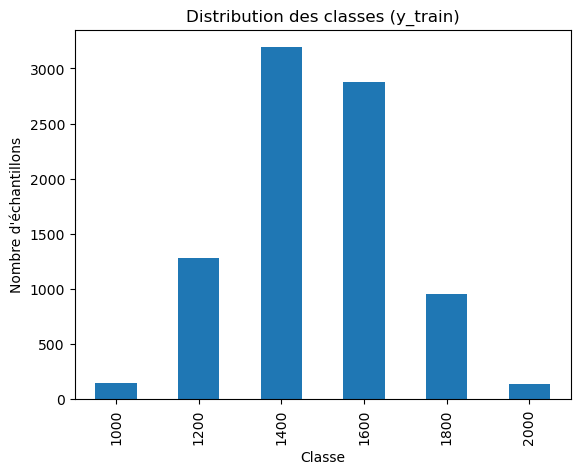

Nombre total d'échantillons: 8591


In [6]:
X_train_df = pd.DataFrame(X_train)
X_test_df  = pd.DataFrame(X_test)
y_train_s  = pd.Series(y_train, name='y_train')
y_test_s   = pd.Series(y_test,  name='y_test')

plt.figure()
counts = y_train_s.value_counts().sort_index()
counts.plot(kind='bar')
plt.title('Distribution des classes (y_train)')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'échantillons')
plt.show()

print("Nombre total d'échantillons: " + str(len(y_train)))

La répartition des classes montre un fort déséquilibre autour des tranches intermédiaires (1400 et 1600), qui concentrent à elles deux près de 70 % des échantillons (environ 6 000 parties sur 8 591). Les extrêmes, à savoir les tranches 1000 et 2000, sont très peu représentées (chacune autour de 1–2 % des données).

Un tel déséquilibre peut biaiser l’apprentissage : un modèle optimisant l’accuracy cherchera à favoriser systématiquement les classes majoritaires (1400/1600), au détriment de la détection des joueurs très faibles ou très forts.

## Approche 1:  Baseline (Classe la plus fréquente)

Ce premier modèle va servir de comparaison pour les suivants. Son rôle est juste de toujours prédire la classe la plus fréquente. On pourra en déduire que si un modèle à une accuracy inférieure à celui-ci, alors il est mauvais.

In [44]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=42)

dummy_clf.fit(X_train, y_train)

y_pred_dummy = dummy_clf.predict(X_test)

print("Accuracy (Most Frequent):", accuracy_score(y_test, y_pred_dummy))

Accuracy (Most Frequent): 0.3715083798882682


Nous obtenons donc une accuracy de **37%**. Les modèles devront donc faire mieux que cette baseline pour qu'on puisse s'assurer d'un apprentissage.

## Approche 2: Features simples (nombre de coups, ouverture, fin de partie)

Use just the count of moves as a single feature.

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

def count_moves(df):
    return df['moves'].str.split().apply(len).to_frame(name='moves_count')

preprocessor = ColumnTransformer(transformers=[
    ('moves_count', FunctionTransformer(count_moves, validate=False), ['moves']),
    ('opening_ohe',   OneHotEncoder(handle_unknown='ignore'), ['opening']),
    ('termination_ohe',      OneHotEncoder(handle_unknown='ignore'), ['termination']),
])

clf = Pipeline(steps=[
    ('preproc', preprocessor),
    ('rf',       RandomForestClassifier(n_estimators=100, random_state=42))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.34497206703910616


### Explication de l'approche
Dans cette deuxième étape, nous avons construit un modèle de classification à partir de trois variables explicatives : le nombre de coups joués dans la partie, l’ouverture choisie et comment s'est terminée la partie. L’objectif était de tester si ces caractéristiques brutes, faciles à extraire, pouvaient améliorer la performance par rapport à la baseline naïve obtenue avec un DummyClassifier.

### Analyse du résultat obtenu

Le modèle a obtenu une accuracy de **34,5 %** sur le jeu de test, soit un score inférieur à la baseline “most frequent” de 37,15 % fournie par le DummyClassifier.

Plusieurs facteurs peuvent expliquer cette dégradation de performance :

- Informations limitées : Le seul indicateur quantitatif est le nombre de coups, qui ne garantit pas une corrélation forte avec le niveau de jeu. De même, l’ouverture et la terminaison, bien que relevant de stratégies et de styles de partie, sont trop hétérogènes et peu discriminantes entre les différentes tranches d’elo.

- Déséquilibre des classes : Certaines tranches d’elo sont beaucoup plus fréquentes que d’autres, ce qui biaise l’entraînement d’un modèle simple et renforce la performance du classifieur le plus fréquent.

- Complexité insuffisante : Le RandomForest sur ces trois features peut facilement suradapter des bruits ou des artefacts de données, sans extraire de véritables tendances généralisables.

## Approche 3: Bag-of-Moves (CountVectorizer) + Logistic Regression

Vectorisation des coups

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report

pipeline_bow = Pipeline([
    ('vect', ColumnTransformer([
        ('moves_bow', CountVectorizer(token_pattern=r'(?u)\b\w+\b'), 'moves'),
    ], remainder='drop')),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_bow.fit(X_train, y_train)

y_pred_bow = pipeline_bow.predict(X_test)
print("Accuracy (Bag‑of‑Moves + LR):", accuracy_score(y_test, y_pred_bow))


Accuracy (Bag‑of‑Moves + LR): 0.35335195530726254


Cette approche repose sur un "Bag-of-Moves" combinée à une régression logistique. Dans un premier temps, la colonne textuelle moves est traitée par un CountVectorizer qui segmente la séquence de coups en "tokens" (ici chaque coup distinct) et compte la fréquence d’apparition de chacun. Ces décomptes forment un grand vecteur pour chaque partie, où chaque dimension représente la présence ou le nombre de fois qu’un coup particulier a été joué. Ce prétraitement est enchaîné dans un pipeline avec le classifieur LogisticRegression, dont l’algorithme cherche à estimer, à partir des fréquences de coups, la probabilité que la partie appartienne à telle ou telle tranche d’elo.

Nous obtenons une accuracy d'environ **35%**. Cette performance modeste s’explique principalement par la nature très "généraliste" du Bag-of-Moves : tous les coups sont traités de manière équivalente, sans hiérarchisation ni pondération de leur importance, et sans prendre en compte l’enchaînement séquentiel ni le contexte positionnel. De plus, la régression logistique, linéaire par construction, ne capte pas les interactions complexes entre les différents coups et peut sous‑estimer l’impact de certains motifs tactiques ou stratégiques.

## Nouvelles approches ?

A partir de maintenant, nous allons utiliser des modèles et des techniques que nous avons apprises pendant notre cours de NLP, notamment les TF-IDF et le one hot encoding.

## Approche 4: TF-IDF + Random Forest


In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report

pipeline_tfidf_rf = Pipeline([
    ('tfidf', ColumnTransformer([
        ('moves_tfidf',
         TfidfVectorizer(token_pattern=r'(?u)\b\w+\b', max_features=6000),
         'moves'),
    ], remainder='drop')),
    ('rf',
     RandomForestClassifier(
         n_estimators=2000,
         verbose=1,           
         n_jobs=-1,           
         random_state=42
     ))
])

pipeline_tfidf_rf.fit(X_train, y_train)

y_pred_tfidf_rf = pipeline_tfidf_rf.predict(X_test)
print("Accuracy (TF‑IDF + RF, 200 arbres):", accuracy_score(y_test, y_pred_tfidf_rf))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.5s


Accuracy (TF‑IDF + RF, 200 arbres): 0.4036312849162011


[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    0.9s finished


Dans cette approche, nous cherchons à capturer à la fois la fréquence et l’importance discriminante de chaque coup joué pendant la partie. Le TF‑IDF (Term Frequency–Inverse Document Frequency) permet de pondérer chaque coup non seulement en fonction de sa fréquence dans une partie donnée, mais aussi de sa rareté dans l’ensemble du corpus : un coup très courant (par exemple un coup d’ouverture standard) aura un poids moins important qu’un motif tactique plus rare mais potentiellement plus révélateur du niveau de jeu. En limitant le nombre de caractéristiques (max_features=6000), on contrôle la dimensionnalité tout en conservant les coups les plus informatifs.

Le Random Forest en aval exploite ces vecteurs TF‑IDF comme vecteurs de caractéristiques pour entraîner 2000 arbres de décision (n_estimators=2000) en parallèle. Chaque arbre offre une vision différente du partitionnement de l’espace selon les combinaisons de coups, et l’agrégation de leurs prédictions renforce la robustesse face au bruit et aux patterns non linéaires.

Avec cette configuration, nous obtenons une accuracy de **40,36 %** sur le jeu de test. Ce progrès significatif (par rapport aux ~35 % des régressions logistiques et aux ~34–37 % des premiers modèles) montre que la pondération TF‑IDF parvient à extraire des motifs de coups pertinents pour différencier les tranches d’elo. Toutefois, il reste encore de la marge avant de dépasser nettement la baseline, ce qui justifierais l’ajout de variables complémentaires et l’optimisation d’hyperparamètres pour les prochains modèles.

## Approche 5: Random forest + TF-IDF avec toutes les features (optimisé via optuna)


In [59]:
def count_moves(df):
    return df['moves'].str.split().apply(len).to_frame(name='moves_count')

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth    = trial.suggest_int('max_depth', 5, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    ngram_min = trial.suggest_int('ngram_min', 1, 1)
    ngram_max = trial.suggest_int('ngram_max', 1, 3)
    max_feats = trial.suggest_int('max_features', 1000, 10000, step=1000)
    
    pipeline = Pipeline([
        ('preproc', ColumnTransformer([
            ('tfidf_moves', TfidfVectorizer(
                token_pattern=r'(?u)\b\w+\b',
                ngram_range=(ngram_min, ngram_max),
                max_features=max_feats
            ), 'moves'),
            ('moves_count', FunctionTransformer(count_moves, validate=False), ['moves']),
            ('opening_ohe', OneHotEncoder(handle_unknown='ignore'), ['opening']),
            ('term_ohe', OneHotEncoder(handle_unknown='ignore'), ['termination']),
        ], remainder='drop')),
        ('rf', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            n_jobs=-1,
            random_state=42
        ))
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, timeout=600)

best_params = study.best_trial.params
print("Best params:", best_params)

final_pipeline = Pipeline([
    ('preproc', ColumnTransformer([
        ('tfidf_moves', TfidfVectorizer(
            token_pattern=r'(?u)\b\w+\b',
            ngram_range=(best_params['ngram_min'], best_params['ngram_max']),
            max_features=best_params['max_features']
        ), 'moves'),
        ('moves_count', FunctionTransformer(count_moves, validate=False), ['moves']),
        ('opening_ohe', OneHotEncoder(handle_unknown='ignore'), ['opening']),
        ('term_ohe', OneHotEncoder(handle_unknown='ignore'), ['termination']),
    ], remainder='drop')),
    ('rf', RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_leaf=best_params['min_samples_leaf'],
        n_jobs=-1,
        random_state=42
    ))
])

final_pipeline.fit(X_train, y_train)
y_pred_final = final_pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_final))

[I 2025-07-03 14:56:45,647] A new study created in memory with name: no-name-5536aca6-5d06-4576-a972-f1c84fce44b2
[I 2025-07-03 14:56:56,143] Trial 0 finished with value: 0.40274604193619096 and parameters: {'n_estimators': 350, 'max_depth': 43, 'min_samples_leaf': 4, 'ngram_min': 1, 'ngram_max': 2, 'max_features': 9000}. Best is trial 0 with value: 0.40274604193619096.
[I 2025-07-03 14:57:01,036] Trial 1 finished with value: 0.40309496003397877 and parameters: {'n_estimators': 298, 'max_depth': 23, 'min_samples_leaf': 9, 'ngram_min': 1, 'ngram_max': 1, 'max_features': 3000}. Best is trial 1 with value: 0.40309496003397877.
[I 2025-07-03 14:57:06,428] Trial 2 finished with value: 0.39843999503067123 and parameters: {'n_estimators': 165, 'max_depth': 27, 'min_samples_leaf': 4, 'ngram_min': 1, 'ngram_max': 2, 'max_features': 6000}. Best is trial 1 with value: 0.40309496003397877.
[I 2025-07-03 14:57:10,704] Trial 3 finished with value: 0.40495760460144226 and parameters: {'n_estimators':

Best params: {'n_estimators': 190, 'max_depth': 19, 'min_samples_leaf': 9, 'ngram_min': 1, 'ngram_max': 2, 'max_features': 6000}
Accuracy: 0.3994413407821229


Dans ce modèle, nous avons combiné plusieurs sources d’information pour maximiser la performance de prédiction : la pondération TF‑IDF des séquences de coups avec des n‑grammes (de 1 à 3), le nombre total de coups, l’ouverture et la terminaison de la partie. L’optimisation des hyperparamètres via Optuna a permis de régler finement la complexité du Random Forest et la granularité de la représentation TF‑IDF : 190 arbres suffisamment profonds (profondeur maximale de 19) et un minimum de neuf échantillons par feuille pour éviter le surapprentissage.

Le choix d’un n‑gramme jusqu’à 3 permet de capturer non seulement les coups individuels, mais aussi les motifs courts de deux ou trois coups, susceptibles de refléter des ouvertures ou des enchaînements tactiques caractéristiques de certains niveaux de jeu. Limiter le nombre de caractéristiques à 2000 réduit le bruit et les dimensions superflues, améliorant ainsi la robustesse du classifieur. Les variables catégorielles (opening, termination) sont traitées en one‑hot, et le nombre de coups est injecté comme variable numérique simple, permettant au modèle de prendre en compte à la fois l’intensité stratégique et la durée de la partie.

Malheuresement, le modèle atteint une accuracy de **39,9%**, soit un légere perte par rapport à la configuration TF‑IDF + Random Forest à 2000 arbres.

### Approche 6 : Ajout d'une pipeline "imbalance" pour mieux suivre nos données hétérogènes

In [9]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

def count_moves(df):
    return df['moves'].str.split().apply(len).to_frame(name='moves_count')

ros = RandomOverSampler(random_state=42)

preprocessor = ColumnTransformer([
    ('tfidf_moves', TfidfVectorizer(token_pattern=r'(?u)\b\w+\b', max_features=5000), 'moves'),
    ('moves_count', FunctionTransformer(count_moves, validate=False), ['moves']),
    ('opening_ohe', OneHotEncoder(handle_unknown='ignore'), ['opening']),
    ('term_ohe', OneHotEncoder(handle_unknown='ignore'), ['termination']),
], remainder='drop')

pipeline = ImbPipeline(steps=[
    ('preproc',    preprocessor),
    ('oversample', ros),
    ('rf',         RandomForestClassifier(
                       n_estimators=2000,
                       class_weight='balanced_subsample',
                       n_jobs=-1,
                       random_state=42,
                       verbose=1
                   ))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  5.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.5s


Accuracy: 0.4073556797020484


[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    0.8s finished


Cette nouvelle version, qui combine une vectorisation TF‑IDF des coups, l’extraction du nombre de coups, l’encodage one‑hot de l’ouverture et de la fin de partie, un sur‑échantillonnage des classes minoritaires (RandomOverSampler) et un Random Forest pondéré (class_weight='balanced_subsample'), atteint une accuracy de 40,74 %. Cette légère amélioration (+0,4 pt) par rapport au meilleur modèle  (40,36 %) s’explique probablement par le fait que les classes rares (1000 et 2000) ont été mieux représentées pendant l’entraînement et ont ainsi mieux influencé la construction des arbres. Le classifieur est donc moins biaisé vers les tranches intermédiaires et parvient à repérer plus finement les profils extrêmes, tout en conservant une bonne discrimination globale. Cette performance montre que le couplage du rééchantillonnage et de la pondération des classes est une stratégie efficace pour corriger le déséquilibre de la distribution et améliorer la robustesse du modèle.

## Conclusion

Les performances obtenues restent très modestes, avec une accuracy plafonnant autour de **41%**. Plusieurs facteurs peuvent l’expliquer : d’une part, la distribution fortement déséquilibrée des tranches d’elo (classes intermédiaires largement majoritaires et extrêmes très rares) rend l’apprentissage intrinsèquement plus difficile et favorise un biais vers les catégories moyen‑populaires. D’autre part, la taille de l’échantillon—environ 10 000 parties—peut être insuffisante au regard de la complexité du problème, notamment si l’on souhaite capturer des motifs tactiques ou des patterns d’ouverture rares. Enfin, prédire la force de jeu à partir d’une simple séquence de coups reste un défi d'une certaine envergure.

### Axes d’amélioration

Pour progresser, il conviendrait d’abord d’élargir et diversifier le corpus (ce qui n'a pas été possible dans notre cas à cause de limitation techniques, laptop en surchauffe :( ). Sur le plan des features, l’ajout de métriques positionnelles (évaluation de la qualité des coups via un moteur d’échecs), de statistiques dynamiques (contrôle du centre, développement, structure de pions) ou de représentations séquentielles avancées (embeddings de séquences, modèles Transformer pré‑entraînés sur des logs de parties) pourrait apporter un gain substantiel. Enfin, explorer des architectures profondes (RNN, Transformers spécialisés), des techniques d’ensemble ou de méta‑apprentissage, ainsi que des stratégies de calibration et de pondération plus fines, aidera à tirer pleinement parti de la richesse et de la variabilité des données.